In [1]:
import os
import time
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import argparse

from vae import VAE
from utils.memory import Memory
from utils.get_pixel_state import get_pixel_state
from c_mcts_args import parse_args

import sys
sys.argv=['']

In [2]:
args = parse_args()

 # CUDA setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Env setup
# Env Setup
c_map = [
    "SFFHFFFF",
    "FFFFFFFF",
    "HFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHFHF",
    "FFFHFFFG",
]
env = gym.make("FrozenLake-v1",  render_mode = "rgb_array", map_name = "8x8", is_slippery=False)

# Memory setup
memory = Memory(env, args)

# VAE setup
vae = VAE(args)
vae.load("models/FL_vae_8x8.pth")

Using device:  cuda


In [21]:
# Gather data
states = []
env.reset()
state = get_pixel_state(env)
states.append(state)
terminated = False

# Gather data
for step in range (0, args.vae_n_steps):

    # Step in environment
    action = env.action_space.sample()
    _, _, terminated, _, _ = env.step(action)
    next_state = get_pixel_state(env)
    states.append(state)

    if terminated:
        env.reset()
        state = get_pixel_state(env)
        terminated = False
    else:
        state = next_state


# Forward pass
states = torch.stack(states).to(device)
z_states = vae.encode(states)
r_states = vae.decode(z_states)

In [22]:
def plot(i):
    fig = plt.figure(figsize=(15,8))
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    img = np.transpose(states[i].cpu().numpy(), [1,2,0])
    plt.imshow(img)
    plt.title("Original")

    fig.add_subplot(rows, columns, 2)
    r_img_a = np.transpose(r_states[i].cpu().detach().numpy(), [1,2,0])
    plt.imshow(np.squeeze(r_img_a))
    plt.title("Model")

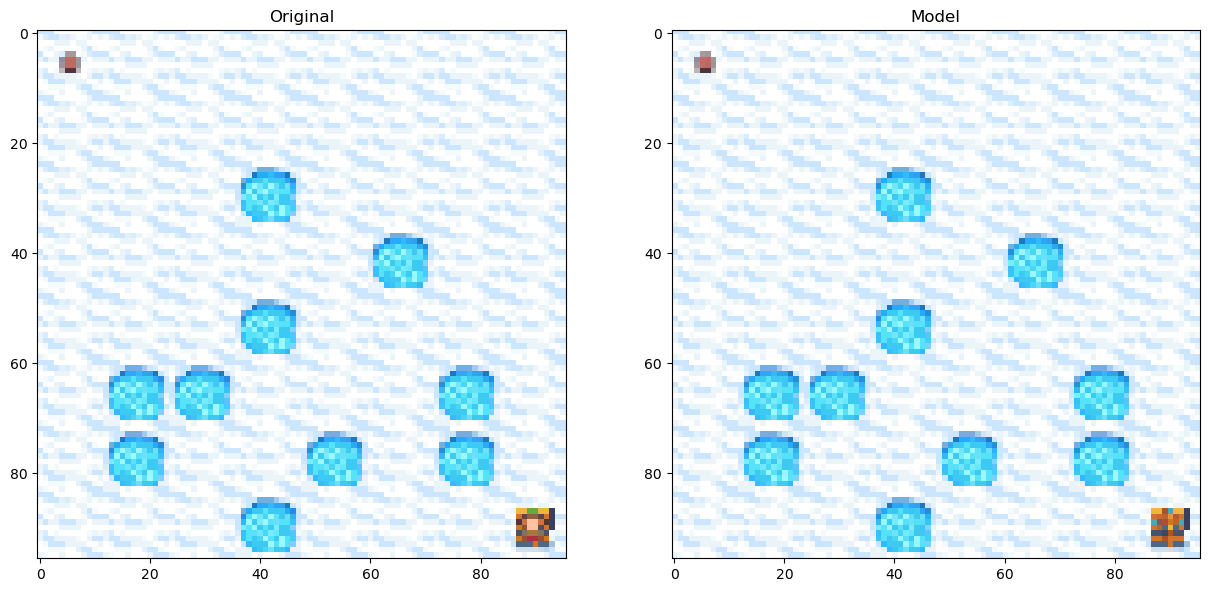

In [31]:
plot(14)